In [31]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob
import tensorflow as tf
from tensorflow import keras

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [72]:
max_sequence = 9
blank_num = -1
characters_0 = '0123456789'
characters_alphabet = 'ABCDEFGHIJKLMNPQRSTUVWXYZ-'
characters_1 = '가나다라마바사아자하거너더러머버서어저허고노도로모보소오조호구누두루무부수우주'
characters_1d = 'GNDLMBSOJHgndlmbsojhgNDLMBSOJHGNDLMBSUJ'
characters_2 = '대배해제기교표외인천국합육공영준협정울경강원충북운남전산광'
characters_2d = 'DBHJGGPYICGHUGYJHJUGKWCBUNJSG'
characters_3 = '_       abcd  '
plate_characters = characters_0 + characters_alphabet + characters_1 + characters_2 + characters_3
num_classes = len(plate_characters)
num_classes

118

In [50]:
EOS = k - 1
SOS = EOS - 1
head_n = 8
l1 = 1e-8
activation = 'relu'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
path_weight = "model/LPR"
SOS, EOS

(116, 117)

In [3]:
np.set_printoptions(precision=3)

In [4]:
def generate_HK_GT(max_m, is_synthetic=False):
    
    path_root = '/media/cvpr/3tb/sogangori/'
    if is_synthetic:
        path_pre = path_root + 'PycharmProjects/plate_gen/gen/'
        path_label = 'label.csv'
        df = pd.read_csv(path_pre + path_label, sep=' ')
    else:
        path_pre = path_root + 'Downloads/dataset/HK_dataset/'
        path_label = 'HK_dataset_20200101.txt'
        df = pd.read_csv(path_pre + path_label, sep=' ', header=None)
        columns = ['path', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'type', 'text']
        df.columns = columns

    print('csv_path', path_pre + path_label)
    print('df.shape',df.shape)
    print('unique_path',df['path'].nunique())
    print('per_type_count')
    print(df['type'].value_counts())

    m = np.minimum(max_m, len(df))
    df = df[:m]

    print('unique_path', len(df), df['path'].nunique())
    print('duplicated', df.duplicated(subset=None, keep='first').sum())
    print('duplicated[path]', df['path'].duplicated().sum())
    duple_index = df[df['path'].duplicated()].index
    #print('duplicated', df[df['path'].duplicated()])
    #duple_concat = pd.concat((df.iloc[duple_index,['path', 'text']],df.iloc[duple_index+1,'path', 'text']))
    #print(df.iloc[duple_index-1])
    #print(df.iloc[duple_index])
    for i in range(len(df)):
        if not os.path.exists(path_pre + df.loc[i, 'path']):
            print('drop_not_exist_path', df.loc[i, 'path'])
            df = df.drop(index=i)

    df['path'] = path_pre + df['path']
    labels = df.values

    paths = df['path'].values
    labels = split_text(labels)
    return df.columns, labels, paths

def split_text(labels):

    #import environment as env
    new_labels = []
    for i in range(len(labels)):
        label = labels[i]
        #print('label',i,label)
        coord = label[1:10]
        text = label[10]
        char_position = label[11:]

        text_arr = np.array(list(text))
        text_num = np.zeros(max_sequence, np.int32) + blank_num
        for k in range(len(text_arr)):            
            try:
                index = plate_characters.index(text_arr[k])
            except:
                print('exception_split_text', text_arr[k],'in',text)
                exit()
            text_num[k] = index

        label_arr = np.concatenate((coord, text_num, char_position), -1)
        new_labels.append(label_arr)
        #new_labels.append(np.stack(new_label, 0))

    new_labels = np.stack(new_labels, 0)
    c = np.shape(label_arr)[-1]
    new_labels = np.reshape(new_labels, [-1, c])
    print('new_labels', new_labels.shape, new_labels[0], 'max', np.max(new_labels))

    return new_labels


def exploration_low_frequency_class(numbers):
    print('numbers', numbers.shape)
    numbers_flat = np.reshape(numbers, [-1])
    characters = []
    for i in range(len(numbers_flat)):
        characters.append(plate_characters[numbers_flat[i]])
    print('characters', characters)
    characters_flat = np.reshape(characters, [-1])
    df_num = pd.DataFrame(numbers_flat)
    df = pd.DataFrame(characters_flat)
    char_value_count = df[0].value_counts()
    class_count = df_num[0].value_counts()
    thresh = len(numbers)*0.01
    #print('characters_flat', char_value_count[char_value_count<thresh])
    print('characters_flat', char_value_count[char_value_count<thresh])
    print('class_count', class_count[class_count<thresh])
    sparse_class_num = class_count[class_count < thresh].index
    print('sparse_class', sparse_class_num)
    return sparse_class_num

def exploration(types, numbers):
    #https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    #weight_for_0 = (1 / neg) * (total) / 2.0
    #weight_for_1 = (1 / pos) * (total) / 2.0
    #set_chinese()
    import matplotlib as mpl

    print('types', types)

    if True:
        types_flat = np.reshape(types, [-1]).astype(np.int)
        df = pd.DataFrame(types_flat)
        value_count = df[0].value_counts()
        print('LP types', value_count)
        max_freq_c1 = max(value_count)
        print('types frequency', max_freq_c1, max_freq_c1/sum(value_count))

    plt.hist(types)
    plt.savefig('types.png')
    plt.close()
    m = len(numbers)
    char_number_flat = np.reshape(numbers, [-1]).astype(np.int)
    df = pd.DataFrame(char_number_flat)
    print('df', df.shape)
    china_char = df[0]
    china_char_count_sort = china_char.value_counts()
    print(china_char_count_sort)

    if True:
        value = df[0]
        cond_0 = value < 10
        cond_1 = np.logical_and(value >= 10+25, value < k-5)
        class_0 = df[cond_0][0]
        class_1 = df[cond_1][0]
        max_freq_c1 = max(class_1.value_counts())
        len_cond_0 = max(class_0) - min(class_0) + 1
        len_cond_1 = max(class_1) - min(class_1) + 1
        #plt.figure(figsize=(10, 5))
        plt.hist(class_0, bins=len_cond_0, color='r', label='digit')
        plt.hist(class_1, bins=len_cond_1, color='g', label='Korean')
        plt.legend()
        from matplotlib import font_manager
        fontP = font_manager.FontProperties()
        #fontP.set_file('../simhei.ttf')
        #plt.legend(prop=fontP)
        x_label = plate_characters
        #plt.xlabel(x_label, fontproperties=fontP)

        print('unique_character', value.nunique(), value.unique())
        print('alphabet frequency', max_freq_c1, max_freq_c1/sum(cond_1))
        plt.savefig('char_count_all.png')
        plt.close()

    frequency = np.zeros(k)
    cls_num = china_char_count_sort.index
    cls_freq = china_char_count_sort.values
    frequency[cls_num] = cls_freq
    #weight = ((1+frequency) / np.sum(frequency))
    np.set_printoptions(precision=4, suppress=True, linewidth=150)
    print('frequency', frequency)


def get_class_index(m):
    info, labels, paths = generate_HK_GT(m, is_synthetic=False)
    cls = labels[:, 9:]
    char_number_flat = np.reshape(cls, [-1]).astype(np.int)
    df = pd.DataFrame(char_number_flat)
    cls_unique = df[0].value_counts()
    print('cls_unique', cls_unique)
    print('index', cls_unique.index)
    cls_unique = cls_unique.index[cls_unique.index<100]
    print('cls_unique', cls_unique)
    return cls_unique

In [5]:
m = 10#2500
#get_class_index(100)

info, labels, paths = generate_HK_GT(m, is_synthetic=False)
print('info', info)
print('labels', len(labels), len(paths), labels[0])


csv_path /media/cvpr/3tb/sogangori/Downloads/dataset/HK_dataset/HK_dataset_20200101.txt
df.shape (1469, 11)
unique_path 1437
per_type_count
1    1027
3     170
4     126
2     110
5      33
6       3
Name: type, dtype: int64
unique_path 10 10
duplicated 0
duplicated[path] 0
new_labels (10, 18) [403 325 567 276 569 313 405 366 1 4 9 56 0 1 5 1 -1 -1] max 671
info Index(['path', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'type', 'text'], dtype='object')
labels 10 10 [403 325 567 276 569 313 405 366 1 4 9 56 0 1 5 1 -1 -1]


In [6]:
x_list = []
y_list = []
for i in range(len(paths)):
    path_img = paths[i]
    label = labels[i]
    if os.path.isfile(path_img):
        img = Image.open(path_img)
        arr = np.array(img)
        
        
        img_h, img_w, img_c = arr.shape
        #print('label', label.shape)
        coord = label[:8]
        type_text = label[8:]        
        coord_2d = np.reshape(coord, [-1, 2])
        coord_2d_norm = coord_2d / (np.array((img_w, img_h), np.float))
        coord_norm = np.reshape(coord_2d_norm, [-1])
        label_norm = np.concatenate((coord_norm, type_text), -1)
        
        x_list.append(arr)
        y_list.append(label_norm)
        
print('x_list', len(x_list), len(y_list))

x_list 10 10


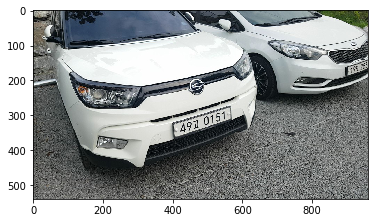

In [7]:
plt.imshow(x_list[0])

In [8]:
def visualize_plate(
    image, y, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""    
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    vertices_norm = y[:8]    
    plate_type = y[8]
    plate_text = y[9:]
    vertices_norm_2d = np.reshape(vertices_norm, [-1, 2])
    vertices_2d = vertices_norm_2d * np.array((img_w, img_h), np.float)
    
    x0, y0, x1, y1, x2, y2, x3, y3 = np.reshape(vertices_2d, [-1])
    
    w, h = x2 - x1, y2 - y1    
    color = [1,0,0]
    linewidth = 10
    plt.plot(x0, y0, x1, y1, 'go-', linewidth=linewidth)
    plt.plot(x1, y1, x2, y2, 'ro--', linewidth=linewidth)
    plt.plot(x2, y2, x3, y3, marker = 'o', linewidth=linewidth)
    plt.plot(x3, y3, x0, y0, marker = 'o', linewidth=linewidth)
        
    txt = str(plate_type) + str(plate_text)
    ax.text(x0, y0, txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

In [9]:
def display_data(X, Y, stride=1):
    for i in range(len(X)):
        if i%stride==0:            
            ax = visualize_plate(X[i], Y[i])

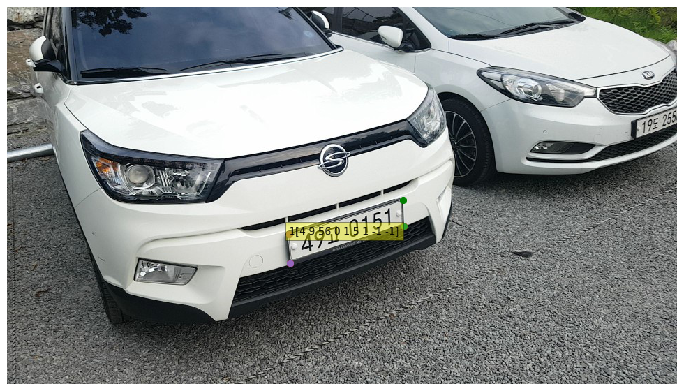

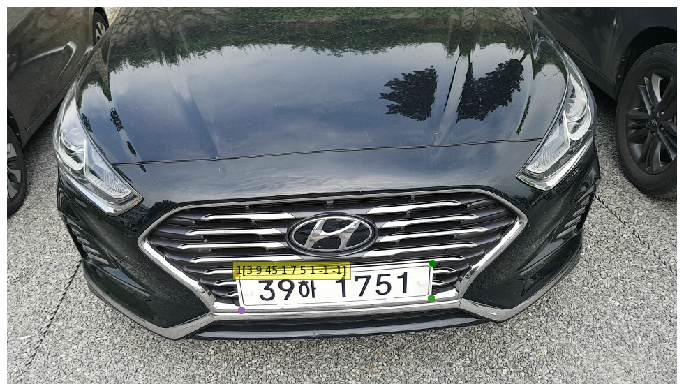

In [11]:
display_data(x_list, y_list, stride=5)

In [15]:
def convert_norm_to_uv(coord):
    return coord * 2 - 1 

def convert_uv_to_norm_to(coord):
    return coord + 1 / 2


def transform_uv(uv, mat):
    #coord : (m, n, 2)
    #theta : (m, 2, 3)    
    inv_mat = tf.linalg.inv(mat)        
    xyo = tf.concat((uv, 1 + 0 * uv[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', inv_mat, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])
    new_xy = new_xy[:, :, :2]
    return new_xy


def transform_xy(xy, theta):
    m = tf.shape(xy)[0]
    theta = tf.linalg.inv(theta)
    theta = theta[:, :2]
    # xy [0, 1] > [-1, 1]
    xy = (xy - 0.5) * 2
    theta = tf.reshape(theta, [-1, 2, 3])
    xy = tf.reshape(xy, [m, -1, 2])
    xyo = tf.concat((xy, 1 + 0 * xy[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', theta, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])

    return new_xy

In [16]:
def get_x1(t1, t2, width, height):
    a = tf.sign(t2) * width - height * tf.sin(t2)/tf.cos(t2)
    b = (tf.sign(t2) * tf.cos(t1) * tf.cos(t2) - tf.sign(t1) * tf.sin(t1) * tf.sin(t2)) / (tf.cos(t1)*tf.cos(t2))
    x1 = a / b
    return x1

def get_v1_v2(t1, t2, width, height):
    x1 = get_x1(t1, t2, width, height)
    #x1 = get_x1_new(t1, t2, width, height)
    y1 = x1 / tf.cos(t1) * tf.sin(t1)
    x2 = width * tf.sign(t2) - tf.sign(t2) * x1
    y2 = height - tf.sign(t1) * y1
    return x1,y1,x2,y2

def get_wH(t1, t2, width, height):
    x1, y1, x2, y2 = get_v1_v2(t1, t2, width, height)
    w = x1/tf.cos(t1)
    h = y2/tf.cos(t2)
    pi = 3.141592653589793
    right = 90 * pi / 180
    H = tf.sin(right - t1 - t2) * h
    return w / width, H / height

def get_align_scale_matrix(radian_x, radian_y, width, height):
    min_angle = 0.0001
    rotate_mat = rotate_matrix(-radian_y)
    shear_x_mat = shear_x_matrix(-radian_x - radian_y)

    radian_x = tf.where(tf.abs(radian_x) < min_angle, tf.sign(radian_x) * radian_x * 0+min_angle, radian_x)
    radian_y = tf.where(tf.abs(radian_y) < min_angle, tf.sign(radian_y) * radian_y * 0+min_angle, radian_y)
    w, h = get_wH(-radian_y, -radian_x, width, height) 
    scale_down_rotate_o = scale_matrix(w, h)

    rot_mat = tf.matmul(rotate_mat, shear_x_mat)
    rot_scale_mat = tf.matmul(rot_mat, scale_down_rotate_o) #[2,3,3] vs [4,3,3]

    return rot_scale_mat

In [17]:
def shift_matrix(x, y):
    z = x * 0
    o = z + 1
    mat = tf.stack([o, z, x, z, o, y], -1)
    row = tf.stack([z, z, z+1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def scale_matrix(x, y):
    z = x * 0
    mat = tf.stack([x, z, z, z, y, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def rotate_matrix(radian):
    c = tf.math.cos(radian)
    s = tf.math.sin(radian)
    z = c * 0
    mat = tf.stack([c, -s, z, s, c, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


def shear_x_matrix(radian_x):
    x = tf.math.tan(radian_x)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, z, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_y_matrix(radian_y):
    y = tf.math.tan(radian_y)
    z = y * 0
    o = z + 1
    mat = tf.stack([o, z, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_matrix(radian_x, radian_y):
    x = tf.math.tan(radian_x)
    y = tf.math.tan(radian_y)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


In [18]:
def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]
    
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])  # (3, h*w)
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    # sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))#(num_batch, 3, h*w)
    sampling_grid = tf.tile(sampling_grid, [num_batch, 1, 1])  # (num_batch, 3, h*w)
    theta = tf.cast(theta, tf.float32)
    sampling_grid = tf.cast(sampling_grid, tf.float32)

    batch_grids = tf.matmul(theta, sampling_grid)  # (m, 2, 3)@(m, 3, h*w)=(m,2,h*w)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])
    return batch_grids


def get_pixel_value(img, x, y):
    # img (m,h,w,c)
    # x,y (m,h,w)
    shape = tf.shape(x)
    m = shape[0]
    h = shape[1]
    w = shape[2]
    batch_idx = tf.range(0, m)
    batch_idx = tf.reshape(batch_idx, [m, 1, 1])
    b = tf.tile(batch_idx, [1, h, w])

    indices = tf.stack([b, y, x], axis=3)  # (m,h,w,3)

    return tf.gather_nd(img, indices)


def bilinear_sampler(img, batch_grids):
    # batch_grids (m, 2, h, w)
    # img (m,h,w,c)
    uv_x = batch_grids[:, 0]
    uv_y = batch_grids[:, 1]
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, tf.float32)
    max_x = tf.cast(W - 1, tf.float32)
    # x [-1, 1]
    x = 0.5 * ((uv_x + 1.0) * max_x)
    y = 0.5 * ((uv_y + 1.0) * max_y)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.floor(x)  # precision bad?
    x1 = x0 + 1
    y0 = tf.floor(y)
    y1 = y0 + 1

    # clip out of boundary index
    x0 = tf.clip_by_value(x0, 0, max_x)
    x1 = tf.clip_by_value(x1, 0, max_x)
    y0 = tf.clip_by_value(y0, 0, max_y)
    y1 = tf.clip_by_value(y1, 0, max_y)

    # deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    wa = tf.expand_dims(wa, -1)
    wb = tf.expand_dims(wb, -1)
    wc = tf.expand_dims(wc, -1)
    wd = tf.expand_dims(wd, -1)

    x0 = tf.cast(x0, tf.int32)
    x1 = tf.cast(x1, tf.int32)
    y0 = tf.cast(y0, tf.int32)
    y1 = tf.cast(y1, tf.int32)

    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
    #out = wa * Ia + wb * Ib + wc * Ic + wd * Id

    return out


def sampling(net, theta, dst_h, dst_w):
    theta = tf.reshape(theta, [-1, 2, 3])
    #h = tf.shape(net)[1]
    #w = tf.shape(net)[2]
    batch_grids = affine_grid_generator(dst_h, dst_w, theta)
    out = bilinear_sampler(net, batch_grids)
    return out

In [19]:
def get_box_center_and_size(bbox):
    x0, y0, x1, y1 = tf.split(bbox, 4, -1)
    w = x1 - x0
    h = y1 - y0
    cx = (x1 + x0) / 2
    cy = (y1 + y0) / 2
    return cx, cy, w, h

In [20]:
X = tf.constant(x_list)
X = tf.cast(X, tf.float32)
Y = tf.constant(y_list)
X.shape, Y.shape, Y[0]

(TensorShape([10, 540, 960, 3]),
 TensorShape([10, 18]),
 <tf.Tensor: shape=(18,), dtype=float32, numpy=
 array([ 0.42 ,  0.602,  0.591,  0.511,  0.593,  0.58 ,  0.422,  0.678,
         1.   ,  4.   ,  9.   , 56.   ,  0.   ,  1.   ,  5.   ,  1.   ,
        -1.   , -1.   ], dtype=float32)>)

In [21]:
def get_theta_from_coords(coords):
    x0 = coords[:, 0, 0]
    y0 = coords[:, 0, 1]
    x1 = coords[:, 1, 0]
    y1 = coords[:, 1, 1]
    x2 = coords[:, 2, 0]
    y2 = coords[:, 2, 1]
    x3 = coords[:, 3, 0]
    y3 = coords[:, 3, 1]
        
    tx = (x0 + x1 + x2 + x3)/4
    ty = (y0 + y1 + y2 + y3)/4
    #scale_x = ((x1 - x0) + (x2 - x3))/2    
    #scale_y = ((y3 - y0) + (y2 - y1))/2
    shear_x = -((x0 - x3) / (y0 - y3) + (x1 - x2) / (y1 - y2)) / 2
    shear_y = -((y1 - y0) / (x1 - x0) + (y2 - y3) / (x2 - x3)) / 2
    shear_x = tf.math.atan(shear_x)
    shear_y = tf.math.atan(shear_y)
    
    x_min = tf.reduce_min(coords[:, :, 0], 1)
    x_max = tf.reduce_max(coords[:, :, 0], 1)
    y_min = tf.reduce_min(coords[:, :, 1], 1)
    y_max = tf.reduce_max(coords[:, :, 1], 1)
    w = x_max - x_min
    h = y_max - y_min
    scale_x = w/2
    scale_y = h/2
    
    return tx, ty, scale_x, scale_y, shear_x, shear_y

In [22]:
def generate_transform_matrix(tx, ty, sx, sy, shear_x, shear_y):    
    shift_mat = shift_matrix(tx, ty)
    scale_mat = scale_matrix(sx, sy)    
    
    w = sx * 2
    h = sy * 2
    align_scale_mat = get_align_scale_matrix(shear_x, shear_y, w, h)    
    tm = tf.matmul(shift_mat, align_scale_mat)
    tm = tf.matmul(tm, scale_mat)
    return tm

In [23]:
def get_align_matrix(vertices_uv):
    cx, cy, sx, sy, shear_x, shear_y = get_theta_from_coords(vertices_uv)        
    transform_mat = generate_transform_matrix(cx, cy, sx, sy, shear_x, shear_y)
    return transform_mat

In [24]:
vertices = Y[:, :8]
plate_type = Y[:, 8]
plate_text = Y[:, 9:]

vertices = tf.reshape(vertices, [-1, 4, 2])
vertices_uv = convert_norm_to_uv(vertices)
transform_mat = get_align_matrix(vertices_uv)
transform_mat.shape

TensorShape([10, 3, 3])

In [25]:
x_sampled = sampling(X, transform_mat[:, :2], 500, 500)
x_sampled.shape

TensorShape([10, 500, 500, 3])

In [26]:
transformed_vertices_uv = transform_uv(vertices_uv, transform_mat)
transformed_vertices_uv.shape, np.sum(np.abs(transformed_vertices_uv.numpy())-1)

(TensorShape([10, 4, 2]), -0.16674405)

In [27]:
x_sampled_img = x_sampled.numpy().astype(np.uint8)
x_sampled_img.shape

(10, 500, 500, 3)

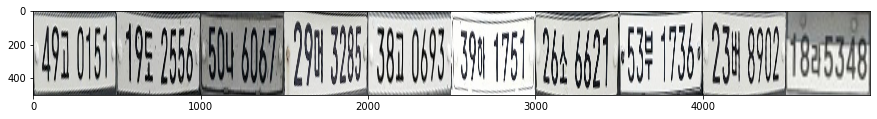

In [28]:
x_sample_concat = np.concatenate((x_sampled_img[:10]), axis=1)
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

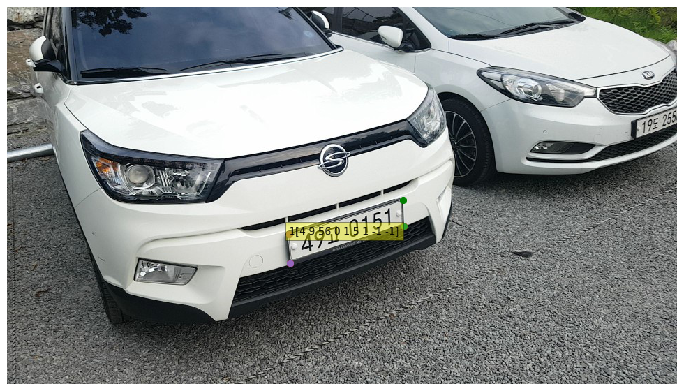

In [29]:
ax = visualize_plate(x_list[0], y_list[0])

In [51]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [54]:
regulizer = tf.keras.regularizers.L2(l1)

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(y)   
    
    if downsample:
        x = Conv2D(kernel_size=3,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer)(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out

def create_resnet_backbone(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(inputs)
    t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    num_blocks_list = [2, 2, 2, 2]#resnet-18
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
    
        
    return t

In [40]:
def position_encoding(max_sequence, seq, dimension_model):

    if max_sequence % 2 == 1:
        max_sequence += 1

    pos = tf.range(max_sequence, dtype=tf.float32)
    pos = tf.reshape(pos, [max_sequence, 1])
    theta = pos/tf.pow(10000.0, tf.range(dimension_model, dtype=tf.float32)/dimension_model)
    emb_even = tf.sin(theta)[:, ::2]
    emb_odd = tf.cos(theta)[:, 1::2]
    emb_even_odd = tf.stack((emb_even, emb_odd), axis=-1)
    emb_even_odd = tf.reshape(emb_even_odd, [max_sequence, dimension_model])
    emb = tf.expand_dims(emb_even_odd[:seq], 0)
    return emb

In [56]:
def masked_multi_head_attention(y, num_units, s, head=head_n):
    '''
    :param y: (m, s, c) > padding >(m, S, c)
    :param x: == y
    :param num_units: 256
    :param head: 4
    :return: (m, s, c)
    '''
    z_expand = tf.expand_dims(y, axis=1)
    one = tf.ones_like(z_expand[:1, :, :, 0])
    one = tf.tile(one, [1, s, 1])

    triangle_mask = tf.linalg.LinearOperatorLowerTriangular(one).to_dense()
    
    QKV = Dense(3 * num_units)(z_expand)
    #QKV = slim.fully_connected(z_expand, 3 * num_units, activation_fn=None, scope='fc_query_key_value')
    QKV = tf.tile(QKV, [1, s, 1, 1])
    QKV = tf.reshape(QKV, [-1, s, 3 * num_units])

    query, key, value = tf.split(QKV, 3, -1)

    Q = tf.concat(tf.split(query, head, axis=-1), 0)
    K = tf.concat(tf.split(key, head, axis=-1), 0)
    V = tf.concat(tf.split(value, head, axis=-1), 0)

    relevant_score = tf.matmul(Q, tf.transpose(K, [0, 2, 1])) / np.sqrt(num_units)  # (m, q_s, c) * (m, c, k_s) = (m, q_s, k_s)
    relevant_score += -10000 * (1 - triangle_mask)
    attention = tf.nn.softmax(relevant_score, axis=-1)
    context = tf.matmul(attention, V)

    attention_list = tf.split(attention, head, axis=0)
    context_list = tf.split(context, head, axis=0)

    attention = tf.reduce_mean(attention_list, axis=0)

    context = tf.concat(context_list, axis=-1)
    context_4d = tf.reshape(context, [-1, s, s, num_units])
    eye = tf.eye(s, s)
    eye = tf.reshape(eye, [1, s, s, 1])
    context = tf.reduce_sum(eye * context_4d, axis=2)

    #context = slim.fully_connected(context, num_units, activation_fn=None, scope='Linear')
    context = Dense(num_units)(context)
    return context, attention


In [58]:
def scale_dot_product_2d(query, key, value, s, h, w, num_units):

    m = tf.shape(query)[0]
    relevant_score = tf.einsum('msc,mhwc->mhws', query, key) / np.sqrt(num_units)

    hw = -1 if env.is_dynamic_shape else h * w
    relevant_score_flat = tf.reshape(relevant_score, [m, hw, s])
    alignment_weights = tf.nn.softmax(relevant_score_flat, axis=1)

    alignment_prob = tf.reshape(alignment_weights, tf.shape(relevant_score))

    context = tf.einsum('mhws,mhwc->msc', alignment_prob, value)

    return context, alignment_prob

In [59]:
def multi_head_attention_qkv(y, x, h, w, num_units, s, is_train, head=head_n):
    num_head_unit = num_units // head
    #query = slim.fully_connected(y, num_units, activation_fn=None, scope='query')
        
    #key_value = slim.conv2d(x, num_units * 2, kernel_size=[3, 3], scope='key_value')
    key = Conv2D(num_units, [3, 3], name='key')
    value = Conv2D(num_units, [3, 3], name='value')
    #key_value = slim.fully_connected(x, num_units * 2, activation_fn=None, scope='key_value')
    #key, value = tf.split(key_value, 2, -1)
    query = y
    Q = tf.concat(tf.split(query, head, axis=-1), 0)
    K = tf.concat(tf.split(key, head, axis=-1), 0)
    V = tf.concat(tf.split(value, head, axis=-1), 0)

    context, attention = scale_dot_product_2d(Q, K, V, s, h, w, num_head_unit)  # (m * head, s, c)

    attention_head = tf.split(attention, head, axis=0)
    attention_head = tf.stack(attention_head, axis=0)

    context_list = tf.split(context, head, axis=0)
    context = tf.concat(context_list, axis=-1)
    #context = tf.cond(tf.logical_and(env.is_ensemble_multi_head, is_train), lambda: dropout_sub_head(context_list, head), lambda: tf.concat(context_list, axis=-1))
    #context = slim.fully_connected(context, num_units, activation_fn=None, scope='linear')

    return context, attention_head

In [60]:
def attention_layer(z, nets, h, w, s, num_units, is_train):
    #z (m, S, num_units)
    #x (m, h, w, ch)

    sub_z, attention_weight = masked_multi_head_attention(z, num_units, s, is_train)
    z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))


    sub_z, attention_head = multi_head_attention_qkv(z, nets, h, w, num_units, s, is_train)
    z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))

    #sub_z = position_wise_feed_forward(z, num_units)
    #z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))

    return attention_head, z

In [66]:
def convert_net_to_score(net, embedding_w):
    embedding_w_trans = tf.transpose(embedding_w)
    score = tf.einsum('nsc,cv->nsv', net, embedding_w_trans)
    return score

In [68]:
def decodeNet(net, num_units):
    
    #keras.layers.Embedding(1000, 64, input_length=10)    
    #z = tf.nn.embedding_lookup(embedding_w, y_symbol)
    y_symbol = tf.zeros_like(inputs[:, 0, 0, :1], dtype=tf.int64) + SOS
    y_symbol = tf.one_hot(y_symbol, env.k)
    for i in range(max_sequence):
        z = tf.einsum('msv,vc->msc', y_symbol, embedding_w)
        z = z * (num_units ** 0.5) + position_encoding(s + 1, i + 1, num_units)
        #z = slim.dropout(z, keep_prob=env.drop_prob_transformer, is_training=is_train)
                
        attention_head, z = attention_layer(z, net, h, w, i+1, num_units, is_train, scope=j)
        value = convert_net_to_score(z, embedding_w)

        last_value = value[:, -1:]
        y_symbol = tf.concat((y_symbol, tf.nn.softmax(last_value)), axis=1)
    
    scores = tf.expand_dims(value, 0)
    
    return attention_head, scores
    

In [65]:
def createModel(num_classes, anchor_k, is_train=False):
    
    
    inputs = Input(shape=(None, None, 3))        
  
    N = tf.shape(image)[0]# TFLite cannot convert tf.shape() function
    #N = 1
    
    net = create_resnet_backbone(inputs/255)    
    attention_head, scores = decodeNet(net, 256)    
    #drop = keras.layers.Dropout(0.1)    
    outputs = scores
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model


In [ ]:

class NetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80):
        super(NetLoss, self).__init__(reduction="auto", name="NetLoss")        
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_hot = tf.onehot(y_true, self._num_classes)
        
        loss = clf_loss + box_loss#new
        return loss

In [70]:
def load_weight():   
    weights_dir = path_weight
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [ ]:
optimizer = tf.optimizers.SGD(learning_rate=1e-5, clipvalue=10.)#warm up clipvalue=10. !
#optimizer = tf.optimizers.SGD(learning_rate=1e-3)#, clipvalue=10.
loss_fn = RetinaNetLoss(num_classes)
model = createModel(num_classes)
model.compile(loss=loss_fn, optimizer=optimizer)

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=100
    )
]